In [ ]:
!pip install catboost lightgbm gensim nltk

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
import os
import pickle
from sklearn.svm import SVC
import lightgbm as lgb

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

#Предобработка данных

In [59]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Samokat/amazon/train_40k.csv')

In [ ]:
train_data.head()

In [ ]:
train_data.value_counts('Cat3')

,count
Cat3,
unknown,2262
shaving hair removal,1565
vitamins supplements,1315
board games,924
styling tools,850
...,...
pork,1
games,1
game collections,1


In [ ]:
threshold = 20
class_counts = train_data['Cat3'].value_counts()

# Замена редких классов на 'Other'
train_data['Cat3'] = train_data['Cat3'].apply(lambda x: x if class_counts[x] > threshold else 'Other')


In [ ]:
train_data.value_counts('Cat3')

,count
Cat3,
unknown,2262
Other,1566
shaving hair removal,1565
vitamins supplements,1315
board games,924
...,...
water treatments,22
aquarium d cor,22
teddy bears,21


In [ ]:
train_data['length'] = train_data['Text'].apply(len)

In [ ]:
train_data = train_data[train_data['Text'].apply(lambda x: len(x) >= 5)]

array([[<Axes: title={'center': 'length'}>]], dtype=object)

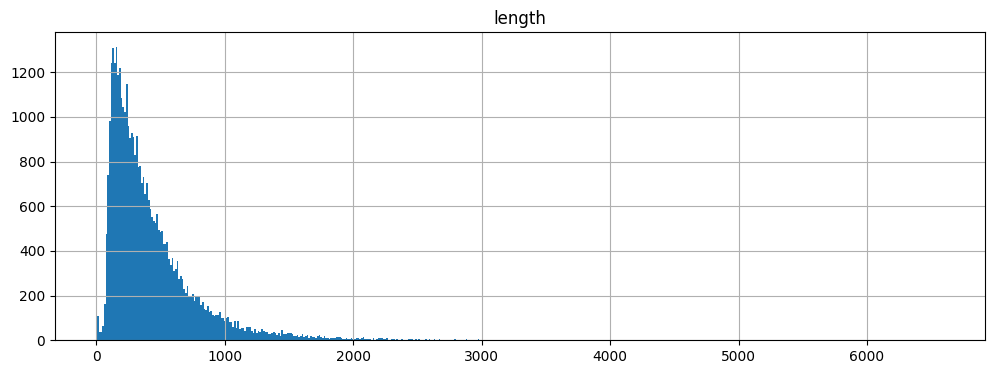

In [ ]:
train_data.hist(column='length', bins=500, figsize=(12,4))

#Реализация класса иерархического классификатора

## Структура Local Classifier per Parent Node (LCPN) - каждый родительский узел получает один многоклассовый классификатор.

In [ ]:
class LCPN_HierarchicalClassifier:

    def __init__(self, base_model):
        self.base_model = base_model
        self.models = {}
        self.label_encoders = {}
        self.vectorizer = TfidfVectorizer()


    def preprocess_text(self, text):
        """
        Функция предобработки текста для корректной векторизации и работы модели
        """
        tokens = word_tokenize(text)
        tokens = [word.lower() for word in tokens if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]
        stemmer = SnowballStemmer('english')
        stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
        return ' '.join(stemmed_tokens)


    def fit(self, train_data, catboost=False):
        """
        Функция тренировки модели.
        Входные данные предобрабатываются и векторизируются методом TfIdf для упрощения.
        На каждый уровень реализуется отдельный LabelEncoder.
        Если уровень больше первого, каждый классификатор тренируется на тех данных,
        которые соответствуют родительскому узлу.
        В словарь models сохраняем модели по определенному уровню и родительскому узлу.
        Также сохраняем label_encoder'ы для будущих предсказаний и определения точности моделей.
        """
        train_data['Processed_Text'] = train_data['Text'].apply(self.preprocess_text)
        X = self.vectorizer.fit_transform(train_data['Processed_Text']).astype(np.float32)

        for level in range(1, 4):
            cat_column = f'Cat{level}'
            label_encoder = LabelEncoder()
            y = label_encoder.fit_transform(train_data[cat_column])

            self.label_encoders[level] = label_encoder

            if level == 1:
                self.models['start'] = self.base_model.fit(X, y) # Если уровень первый, то обучаем на всем дататсете с колонки Cat1
            else:
                self.models[level] = {}
                for label in train_data[f'Cat{level-1}'].unique():
                    indices = train_data[f'Cat{level-1}'] == label
                    X_label = X[indices]
                    y_label = y[indices]

                    if len(set(y_label)) == 1:
                        continue

                    X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.25)

                    if catboost:
                        self.models[level][label] = self.base_model.fit(X_train, y_train)
                    else:
                        self.models[level][label] = self.base_model.set_params(class_weight='balanced').fit(X_train, y_train)

                    y_pred = self.models[level][label].predict(X_test)

                    print(f'--- Level {level}, Parent Label: {label} ---')
                    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
                    print(f'F1 Score: {f1_score(y_test, y_pred, average="macro")}')
                    print(f"Recall score: {recall_score(y_test, y_pred, average='macro')}")
                    print(f"Precision score: {precision_score(y_test, y_pred, average='macro')}")

        return self


    def transform_with_unknown(self, label_encoder, labels):
        """
        Функция работы с отстутствующими метками.
        При получении новых данных мы можем получить неизвестные метки для label encoder,
        что вызывает ошибку.
        Чтобы решить эту проблему функция преобразует метки, заменяя новые метки на 'Unknown'.
        """

        known_labels = set(label_encoder.classes_)
        transformed_labels = []

        for label in labels:
            if label in known_labels:
                transformed_labels.append(label_encoder.transform([label])[0])
            else:
                transformed_labels.append(label_encoder.transform(["Unknown"])[0])

        return np.array(transformed_labels)

    def predict(self, X):
        """
        Функция предсказания.
        Полученные данные векторизуются и подаются поочередно на каждый уровень
        в зависимости от предсказанного класса. Каждое предсказанный класс сохраняется
        в список y_pred_hierarchical.
        Возвращается последний предсказанный класс и список всех классов.
        """

        X = X.apply(self.preprocess_text)
        X_transformed = self.vectorizer.transform(X)

        y_pred_level_1 = self.models['start'].predict(X_transformed)
        y_pred_hierarchical = [y_pred_level_1]

        for level in range(2, 4):
            y_pred_level = np.zeros_like(y_pred_level_1)
            for i, label in enumerate(y_pred_hierarchical[-1]):
                if label in self.models[level]:
                    y_pred_level[i] = self.models[level][label].predict([X_transformed[i]])[0]
                else:
                    y_pred_level[i] = self.label_encoders[level].transform(["Unknown"])[0]
            y_pred_hierarchical.append(y_pred_level)

        return y_pred_hierarchical[-1], y_pred_hierarchical

    def evaluate(self, test_data):
        '''
        Функция оценивания качества на тестовых данных.
        Возвращаеn cловарь metrics, содержащий метрики качества
        (accuracy, f1, recall, precision) для каждого уровня иерархии (Cat1, Cat2, Cat3).
        '''
        test_data['Processed_Text'] = test_data['Text'].apply(self.preprocess_text)
        X_test = self.vectorizer.transform(test_data['Processed_Text']).astype(np.float32)

        metrics = {f'Cat{level}': {'accuracy': [], 'f1': [], 'recall': [], 'precision': []} for level in range(1, 4)}

        y_test_level_1 = self.transform_with_unknown(self.label_encoders[1], test_data['Cat1'])
        y_pred_level_1 = self.models['start'].predict(X_test)

        metrics['Cat1']['accuracy'].append(accuracy_score(y_test_level_1, y_pred_level_1))
        metrics['Cat1']['f1'].append(f1_score(y_test_level_1, y_pred_level_1, average='macro'))
        metrics['Cat1']['recall'].append(recall_score(y_test_level_1, y_pred_level_1, average='macro'))
        metrics['Cat1']['precision'].append(precision_score(y_test_level_1, y_pred_level_1, average='macro'))

        y_pred_hierarchical = [y_pred_level_1]

        for level in range(2, 4):
            y_test_level = self.transform_with_unknown(self.label_encoders[level], test_data[f'Cat{level}'])
            y_pred_level = np.zeros_like(y_test_level)

            for i, label in enumerate(y_pred_hierarchical[-1]):
                if label in self.models[level]:
                    y_pred_level[i] = self.models[level][label].predict([X_test[i]])[0]
                else:
                    y_pred_level[i] = self.label_encoders[level].transform(["Unknown"])[0]

            y_pred_hierarchical.append(y_pred_level)

            metrics[f'Cat{level}']['accuracy'].append(accuracy_score(y_test_level, y_pred_level))
            metrics[f'Cat{level}']['f1'].append(f1_score(y_test_level, y_pred_level, average='macro'))
            metrics[f'Cat{level}']['recall'].append(recall_score(y_test_level, y_pred_level, average='macro'))
            metrics[f'Cat{level}']['precision'].append(precision_score(y_test_level, y_pred_level, average='macro'))

        return metrics


In [ ]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
hc = LCPN_HierarchicalClassifier(base_model)
hc.fit(train_data)

**Результат**:

метрики верхних уровней на тренировочных данных:
- accuracy = 0.6
- F1 = 0.4

Метрики нижних классов показывают очень низкое качество даже на тренировочной выборке. Возможной причиной является недостаток количества тренировочных данных для определенных категорий.

## Структура Local Classifier per Node (LCN) - обучение одного многоклассового классификатора для каждого уровня.

In [ ]:
from gensim.models import Word2Vec

In [ ]:
class LCN_HierarchicalClassifier:

    def __init__(self, base_model):
        self.base_model = base_model
        self.models = {}
        self.label_encoders = {}


    def preprocess_text(self, text):
        tokens = word_tokenize(text)
        tokens = [word.lower() for word in tokens if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]
        stemmer =  SnowballStemmer('english')
        stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
        return ' '.join(stemmed_tokens)

    def fit_word2vec(self, text):
        """
        Функция тренировки word2vec.
        Для нахождения более сложных зависимостей и пополнения признаков
        обучаем word2vec.
        """
        self.word2vec_model = Word2Vec(text)
        self.word2vec_model.train(text, total_examples=len(text), epochs=5)
        return self.word2vec_model

    def text_to_vector(self, text):
        """
        Функция преобразования текста в вектора.
        """
        words = self.preprocess_text(text)
        words_in_vocab = [word for word in words if word in self.word2vec_model.wv]
        if len(words_in_vocab) == 0:
            return np.zeros(100)
        return np.mean([self.word2vec_model.wv[word] for word in words_in_vocab], axis=0)

    def fit(self, train_data, save_model_dir=None):
        """
        Функция тренировки.
        Ход работы аналогичен классу LCPN, но здесь тренировка идет только по уровням,
        поэтому кол-во классификаторов равно кол-ву уровней.
        Также добавлена возможность сохранения весов моделелей.
        """
        train_data['Processed_Text'] = train_data['Text'].apply(self.preprocess_text)
        text = train_data['Processed_Text'].tolist()

        # Преобразование текста в векторы
        X = np.array([self.text_to_vector(text) for text in train_data['Processed_Text']])

        for level in range(1, 4):
            cat_column = f'Cat{level}'
            label_encoder = LabelEncoder()
            y = label_encoder.fit_transform(train_data[cat_column])

            if "Unknown" not in label_encoder.classes_:
                label_encoder.classes_ = np.append(label_encoder.classes_, "Unknown")

            self.label_encoders[level] = label_encoder

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
            self.models[level] = self.base_model.fit(X_train, y_train)

            if save_model_dir:
                model_path = os.path.join(save_model_dir, f'/content/drive/MyDrive/Colab Notebooks/Samokat/weights/model_level_{level}.pkl')
                encoder_path = os.path.join(save_model_dir, f'/content/drive/MyDrive/Colab Notebooks/Samokat/weights/encoder_level_{level}.pkl')
                with open(model_path, 'wb') as model_file:
                    pickle.dump(self.models[level], model_file)
                with open(encoder_path, 'wb') as encoder_file:
                    pickle.dump(self.label_encoders[level], encoder_file)

            y_pred = self.models[level].predict(X_test)

            print(f'--- Level {level} ---')
            print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
            print(f'F1 Score: {f1_score(y_test, y_pred, average="macro")}')
            print(f"Recall score: {recall_score(y_test, y_pred, average='macro')}")
            print(f"Precision score: {precision_score(y_test, y_pred, average='macro')}")

        return self

    def transform_with_unknown(self, label_encoder, labels):
        known_labels = set(label_encoder.classes_)
        transformed_labels = []

        for label in labels:
            if label in known_labels:
                transformed_labels.append(label_encoder.transform([label])[0])
            else:
                transformed_labels.append(label_encoder.transform(["Unknown"])[0])

        return np.array(transformed_labels)

    def predict(self, X, model_dir=None):
        if model_dir:   # Импорт обученной модели
            for level in range(1, 4):
                model_path = os.path.join(model_dir, f'model_level_{level}.pkl')
                encoder_path = os.path.join(model_dir, f'encoder_level_{level}.pkl')
                with open(model_path, 'rb') as model_file:
                    self.models[level] = pickle.load(model_file)
                with open(encoder_path, 'rb') as encoder_file:
                    self.label_encoders[level] = pickle.load(encoder_file)

        X = X.apply(self.preprocess_text)
        X_transformed = self.vectorizer.transform(X)

        y_pred_hierarchical = []

        for level in range(1, 4):
            y_pred_level = self.models[level].predict(X_transformed)
            y_pred_hierarchical.append(y_pred_level)

        return y_pred_hierarchical[-1], y_pred_hierarchical

    def evaluate(self, test_data):
        test_data['Processed_Text'] = test_data['Text'].apply(self.preprocess_text)
        X_test = np.array([self.text_to_vector(text) for text in test_data['Text']])

        metrics = {f'Cat{level}': {'accuracy': [], 'f1': [], 'recall': [], 'precision': []} for level in range(1, 4)}

        y_pred_hierarchical = []

        for level in range(1, 4):
            y_test_level = self.transform_with_unknown(self.label_encoders[level], test_data[f'Cat{level}'])
            y_pred_level = self.models[level].predict(X_test)
            y_pred_hierarchical.append(y_pred_level)

            metrics[f'Cat{level}']['accuracy'].append(accuracy_score(y_test_level, y_pred_level))
            metrics[f'Cat{level}']['f1'].append(f1_score(y_test_level, y_pred_level, average='macro'))
            metrics[f'Cat{level}']['recall'].append(recall_score(y_test_level, y_pred_level, average='macro'))
            metrics[f'Cat{level}']['precision'].append(precision_score(y_test_level, y_pred_level, average='macro'))

            print(f"--- Evaluation results for Cat{level} ---")
            print(f"Accuracy: {np.mean(metrics[f'Cat{level}']['accuracy'])}")
            print(f"F1 Score: {np.mean(metrics[f'Cat{level}']['f1'])}")
            print(f"Recall: {np.mean(metrics[f'Cat{level}']['recall'])}")
            print(f"Precision: {np.mean(metrics[f'Cat{level}']['precision'])}")
            print()

        return metrics


In [ ]:
texts_for_w2v = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Samokat/amazon/unlabeled_150k.csv')['Text']

In [ ]:
from xgboost import XGBClassifier

base_model = XGBClassifier(n_estimators=300, eval_metric="mlogloss", use_label_encoder=False)
classifier = LCN_HierarchicalClassifier(base_model)
classifier.fit_word2vec(texts_for_w2v[:90000]) # Предобучаем word2vec на большом объеме данных


In [ ]:
classifier.fit(train_data, save_model_dir='/content/drive/MyDrive/Colab Notebooks/Samokat/weights')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:51:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Level 1 ---
Accuracy: 0.4139139139139139
F1 Score: 0.3661518509770749
Recall score: 0.358710422904633
Precision score: 0.40518879778503386


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:53:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Level 2 ---
Accuracy: 0.17942942942942944
F1 Score: 0.09499476856939934
Recall score: 0.09066501783777951
Precision score: 0.1300112335870912


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:04:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Level 3 ---
Accuracy: 0.12374874874874875
F1 Score: 0.05119964756174889
Recall score: 0.047663276391831225
Precision score: 0.07213873149849119


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Использование разных моделей:
- Линейные модели не могут найти глубокие скрытые зависимости, поэтому проявляется недообучение.
- Случайный лес склонен к переобучению, поэтому на тестовых данных показывает очень хорошее качество, но на тесте метрики плохие.
- Бустинги показывают себя лучше всего, но они более ресурсозатратные: для обучения всего классификатора на XGBoost потребовалось около 50 минут.


**Результат**:
Модели на каждом уровне работают хуже LCPN + в данной структуре теряются иерархические отношения.

In [ ]:
val_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Samokat/amazon/val_10k.csv')

# Плоский классификатор

Идея: конкатенируем все три категории и подаем в классификатор как класс.

In [60]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Samokat/amazon/train_40k.csv')

In [61]:
train_data['Flat_Class'] = train_data['Cat1'] + ' ' + train_data['Cat2'] + ' ' + train_data['Cat3']

In [63]:
train_data['Flat_Class'].value_counts()

,count
Flat_Class,
health personal care personal care shaving hair removal,1565
health personal care nutrition wellness vitamins supplements,1315
toys games games board games,924
beauty hair care styling tools,850
beauty fragrance women s,737
...,...
toys games novelty gag toys slime putty toys,1
toys games games handheld games,1
toys games puzzles puzzle play mats,1


In [65]:
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import numpy as np
import pickle
import os
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from xgboost import XGBClassifier

class FlatClassifier:

    def __init__(self, base_model):
        self.base_model = base_model
        self.label_encoder = None
        self.word2vec_model = None

    def preprocess_text(self, text):
        # Простая предобработка текста без использования NLTK
        text = text.lower()
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Удаляем короткие слова длиной 1-2 буквы
        text = re.sub(r'\d+', '', text)  # Удаляем числа
        text = re.sub(r'\W+', ' ', text)  # Удаляем все, кроме букв и пробелов
        text = text.strip()
        return text

    def fit_word2vec(self, texts):
        self.word2vec_model = Word2Vec(texts)
        self.word2vec_model.train(texts, total_examples=len(texts), epochs=5)
        return self.word2vec_model

    def text_to_vector(self, text):
        words = self.preprocess_text(text).split()
        words_in_vocab = [word for word in words if word in self.word2vec_model.wv]
        if len(words_in_vocab) == 0:
            return np.zeros(100)
        return np.mean([self.word2vec_model.wv[word] for word in words_in_vocab], axis=0)

    def fit(self, train_data, save_model_dir=None):
        # Объединение категорий в один класс
        train_data['Flat_Class'] = train_data['Cat1'] + ' ' + train_data['Cat2'] + ' ' + train_data['Cat3']

        # Замена редких классов на 'Other'
        threshold = 5
        class_counts = train_data['Flat_Class'].value_counts()
        train_data['Flat_Class'] = train_data['Flat_Class'].apply(lambda x: x if class_counts[x] > threshold else 'Other')

        # Преобразование текста в векторы
        train_data['Processed_Text'] = train_data['Text'].apply(self.preprocess_text)
        text = train_data['Processed_Text'].tolist()
        X = np.array([self.text_to_vector(text) for text in train_data['Processed_Text']])

        # Преобразование класса
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(train_data['Flat_Class'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

        self.base_model.fit(X_train, y_train)

        # Сохранение модели и энкодера,
        if save_model_dir:
            model_path = os.path.join(save_model_dir, '/content/drive/MyDrive/Colab Notebooks/Samokat/weights/flat_model.pkl')
            encoder_path = os.path.join(save_model_dir, '/content/drive/MyDrive/Colab Notebooks/Samokat/weights/flat_encoder.pkl')
            with open(model_path, 'wb') as model_file:
                pickle.dump(self.base_model, model_file)
            with open(encoder_path, 'wb') as encoder_file:
                pickle.dump(self.label_encoder, encoder_file)

        # Оценка модели
        y_pred = self.base_model.predict(X_test)
        print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
        print(f'F1 Score: {f1_score(y_test, y_pred, average="macro")}')
        print(f"Recall score: {recall_score(y_test, y_pred, average='macro')}")
        print(f"Precision score: {precision_score(y_test, y_pred, average='macro')}")

        return self

    def predict(self, X, model_dir=None):

        if model_dir:
            model_path = os.path.join(model_dir, 'flat_model.pkl')
            encoder_path = os.path.join(model_dir, 'flat_encoder.pkl')
            with open(model_path, 'rb') as model_file:
                self.base_model = pickle.load(model_file)
            with open(encoder_path, 'rb') as encoder_file:
                self.label_encoder = pickle.load(encoder_file)

        X = X.apply(self.preprocess_text)
        X_transformed = np.array([self.text_to_vector(text) for text in X])

        y_pred = self.base_model.predict(X_transformed)
        y_pred_classes = self.label_encoder.inverse_transform(y_pred)

        return y_pred_classes


In [67]:
# Инициализация и обучение модели
base_model = XGBClassifier(n_estimators=100, eval_metric="mlogloss", use_label_encoder=False)
flat_classifier = FlatClassifier(base_model)

flat_classifier.fit_word2vec(train_data['Text'].apply(flat_classifier.preprocess_text).str.split())

# Обучение FlatClassifier на первых 9000 записях
flat_classifier.fit(train_data, save_model_dir='/content/drive/MyDrive/Colab Notebooks/Samokat/weights')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:08:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.26525
F1 Score: 0.09368683256859443
Recall score: 0.09110660603217342
Precision score: 0.1148709416646824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
new_data = pd.Series([
    "Cool Game",
    "Toys is cool"
])
flat_classifier.predict(new_data)

array(['toys games games card games',
       'toys games action toy figures figures'], dtype=object)

# ИТОГИ
Мы обучили 3 вида классификации:
- Local Classifier per Parent Node (LCPN) - каждый родительский узел получает один многоклассовый классификатор.
- Local Classifier per Node (LCN) - обучение одного многоклассового классификатора для каждого уровня.
- Flat Classifier ("плоский" классификатор) - обучение на конкатенированных данных.


---
**LCPN**.

Плюсы:
- Хорошее качество моделей относительно других структур.
- Скорость обучения выше остальных (15 минут при обучении XGBoost).

Минусы:
- Сложность обработки редких классов.
- Зависимость от предсказаний на предыдущих уровнях.


---



**LCN**

Качество моделей хуже, скорость обучения ниже (25 минут при обучении XGBoost), более высокая вычислительная сложность.


---
**Плоский** **классификатор**

Не эффективен при работе с большим количеством классов, низкая точность.
Временные затраты растут с увеличением количества классов, но обучение остается достаточно эффективным, поскольку весь процесс сводится к одному вызову алгоритма обучения.